### Customer Spending Profile 
we categorize each customer as either low, medium, or high spending according to their average expense

In [117]:
import pandas as pd
import numpy as np

LABEL_FEATURE = "tot_sales"

indicators = pd.read_csv('../dataset/indicators_no_outlier.csv', index_col="CustomerID")

In [118]:
indicators.describe()

,Entropy,i,iu,imax,tot_sales,mean_sales,num_baskets
count,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000,4161.000000
mean,0.870646,733.105023,53.751262,209.747176,210.612409,62.222123,3.552271
std,0.816643,1061.519728,55.617563,197.669931,260.782225,48.365995,3.748938
min,-0.000000,1.000000,1.000000,1.000000,0.170000,0.170000,1.000000
25%,-0.000000,152.000000,15.000000,80.000000,49.680000,27.700000,1.000000
50%,0.693147,355.000000,34.000000,150.000000,118.350000,49.935000,2.000000
75%,1.386294,876.000000,73.000000,268.000000,262.300000,84.610000,4.000000
max,3.295837,13162.000000,315.000000,1440.000000,2143.240000,318.190000,27.000000


In [119]:
# first try with tot_sales
def label_by_quantiles(label_feature, quantiles):
    if (label_feature < quantiles[10]):
        return "low"
    elif (label_feature < quantiles[15]):
        return "medium"
    else:
        return "high"

def set_label(labelFeature):
    quantiles = []
    
    for i in range(0, 100, 5):
        quantile = indicators[labelFeature].quantile(i/100)
        quantiles.append(quantile)
        #print(f"{i}% quantile: ".format(i)+str(round(quantile, 2)))
        
    df = indicators.copy(deep=True)
    df["spending_profile"] = df[LABEL_FEATURE].apply(lambda x : label_by_quantiles(x, quantiles))
    
    return df

In [120]:
df = set_label(LABEL_FEATURE)
print(df)

             Entropy     i   iu  imax  tot_sales  mean_sales  num_baskets  \
CustomerID                                                                  
12347       1.945910  2458  103   319     481.21   68.744286            7   
12348       1.386294  2341   22  1254     178.71   44.677500            4   
12350      -0.000000   197   17   197      65.30   65.300000            1   
12352       2.079442   473   59    98    1337.42  167.177500            8   
12353      -0.000000    20    4    20      24.30   24.300000            1   
...              ...   ...  ...   ...        ...         ...          ...   
18280      -0.000000    45   10    45      47.65   47.650000            1   
18281      -0.000000    54    7    54      39.36   39.360000            1   
18282       0.693147   103   12    75      62.39   31.195000            2   
18283       2.566599  1357  263    61    1174.33   73.395625           16   
18287       1.098612  1586   59   488     104.55   34.850000            3   

### Computing spending profile label

we begin by plotting the distribution and the quantiles for tot_sales, the feature from which we want to compute our label

<AxesSubplot:ylabel='Frequency'>

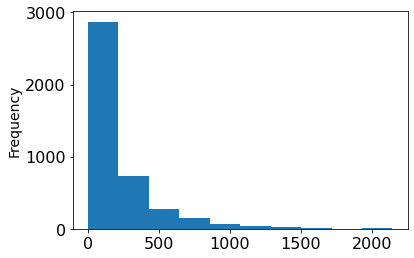

In [121]:
df[LABEL_FEATURE].plot.hist()

We drop the column we used to compute our label in order to proceed with classification

In [122]:
df = df.drop(LABEL_FEATURE, axis=1)

## Discretizing the label

In [123]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [124]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ['spending_profile']
df = discretize_data(df, variables)

## Splitting the dataset

In [125]:
#to classify, we first need to split the dataset into train and test dataset.
#we can do so using train_test_split, in this case we select a stratified split
from sklearn.model_selection import train_test_split
label = df.pop('spending_profile')
train_set, test_set, train_label, test_label = train_test_split(df, label, stratify =label, test_size=0.5)

# discretized sets
train_set_discretized = train_set.copy(deep=True)
test_set_discretized = test_set.copy(deep=True)

train_set = train_set.drop('spending_profile_num', axis=1)
test_set = test_set.drop('spending_profile_num', axis=1)

## Classifier Collection

### Hyperparameters optimization
The performance may slightly be worse for the randomized search, and is likely due to a noise effect and would not carry over to a held-out test set.

Note that in practice, one would not search over this many different parameters simultaneously using grid search, but pick only the ones deemed most important.

In [126]:
#metrics computed on the test set
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
import statistics 

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=["low", "medium", "high"]))

def classification(clf, parameters=None, pscore=True):
    
    if parameters is None:
        classifier = clf
    else:
        classifier = clf(**parameters)
        
    classifier = classifier.fit(train_set, train_label)
    test_pred_clf = classifier.predict(test_set)
    train_pred_clf = classifier.predict(train_set)
    if pscore is True:
        print("============== score report ==============")
        report_scores(test_label, test_pred_clf)
        print("============== accuracy report ==============\n")
        accuracy_on_train(test_pred_clf,train_pred_clf)
        print("\n============== cross report ==============\n")
        clf_cross_validate(classifier)
    
    return classifier

def optimized_hyperparameters(clf, params_range, pscore=True):
    
    rndsearch = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
    
    #run the rndsearch
    rndsearch.fit(train_set, train_label)
    
    if pscore is True:
        print('Mean and std of this setting ', 
              rndsearch.cv_results_['mean_test_score'][0], 
              rndsearch.cv_results_['std_test_score'][0])
        
    return rndsearch.cv_results_['params'][0]

#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
def accuracy_on_train(test_pred_clf,train_pred_clf):
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_clf))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_clf))
    print('Precision train set ', metrics.precision_score(train_label, train_pred_clf, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred_clf, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred_clf, average='weighted'))
    print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_clf))
    

#cross validation
#the score array for test/train scores on each cv split
#the time for fitting/scoring the estimator on the train set for each cv split
def clf_cross_validate(clf):
    scores = cross_validate(clf, train_set, train_label, cv=3, return_train_score= True)
    print('Fit time ', statistics.mean(scores['fit_time']))
    print('Score time ', statistics.mean(scores['score_time']))
    print('Test score ', statistics.mean(scores['test_score']))
    print('Train score ', statistics.mean(scores['train_score']))

## Classification with Decision Tree

In [127]:
from sklearn import tree

param_dict = {"min_samples_split": 3,
              "min_samples_leaf": 4,
              "max_depth": 10,
              "criterion": "gini",
              "splitter": "best"}

dt = classification(tree.DecisionTreeClassifier,param_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.90      0.93      0.91       521
      medium       0.98      0.98      0.98      1040
        high       0.89      0.85      0.87       520

    accuracy                           0.94      2081
   macro avg       0.92      0.92      0.92      2081
weighted avg       0.93      0.94      0.93      2081

============== accuracy report ==============

Accuracy train set  0.9711538461538461
Accuracy test set  0.9351273426237385
Precision train set  0.971166163988086
Recall train set  0.9711538461538461
F1 score train set  0.9711014747591431
Support train set  (array([0.94915254, 0.99039385, 0.95472441]), array([0.96923077, 0.99134615, 0.93269231]), array([0.95908658, 0.99086977, 0.94357977]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.006105581919352214
Score time  0.0024178028106689453
Test score  0.9274070470035888
Train score  0

In [128]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'medium', "high"],  
                         filled=True, rounded=True, rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
graph.write_png('../output/task3/graphviz_dt.png')

True

In [129]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

### Decision Tree evaluation

In [130]:
#compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_label, test_pred_dt)
cm

array([[ 482,    0,   39],
       [   3, 1021,   16],
       [  52,   25,  443]])

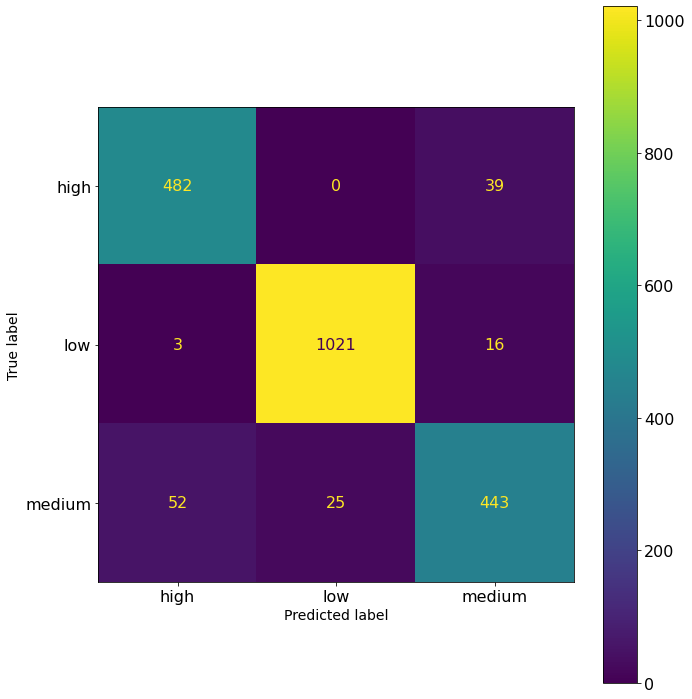

In [131]:
#it is possible to plot the confusion matrix 
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16, "axes.labelsize" : 14})


plot_confusion_matrix(dt, test_set, test_label, ax=ax)
plt.tight_layout()
plt.savefig('../output/task3/confusionmatrix.png')
plt.show() 

## Classification with Naive Bayes

In [132]:
#import, define and fit the model
from sklearn.naive_bayes import GaussianNB

gnb = classification(GaussianNB())

============== score report ==============
              precision    recall  f1-score   support

         low       0.86      0.73      0.79       521
      medium       0.91      0.91      0.91      1040
        high       0.63      0.73      0.68       520

    accuracy                           0.82      2081
   macro avg       0.80      0.79      0.79      2081
weighted avg       0.83      0.82      0.82      2081

============== accuracy report ==============

Accuracy train set  0.8110576923076923
Accuracy test set  0.818356559346468
Precision train set  0.8189067526773212
Recall train set  0.8110576923076923
F1 score train set  0.8130182769672112
Support train set  (array([0.85327314, 0.89952153, 0.62331081]), array([0.72692308, 0.90384615, 0.70961538]), array([0.78504673, 0.90167866, 0.66366906]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.004440784454345703
Score time  0.002494970957438151
Test score  0.810582149198864
Train score  0.8

## Classification with Random Forest

In [133]:
#define and fit a random forest
from sklearn.ensemble import RandomForestClassifier

params_dict = {
    'n_estimators' : 30, 
    'criterion' : 'gini',
    'max_features' : 3,
    'max_depth' : 4, 
    'min_samples_split' : 2,
    'min_samples_leaf' : 8,
    'bootstrap' : True
}

rf = classification(RandomForestClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.90      0.83      0.86       521
      medium       0.94      0.95      0.94      1040
        high       0.75      0.80      0.77       520

    accuracy                           0.88      2081
   macro avg       0.86      0.86      0.86      2081
weighted avg       0.88      0.88      0.88      2081

============== accuracy report ==============

Accuracy train set  0.8971153846153846
Accuracy test set  0.8808265257087938
Precision train set  0.901325449796726
Recall train set  0.8971153846153846
F1 score train set  0.8980876022455029
Support train set  (array([0.91897655, 0.95841393, 0.7694974 ]), array([0.82884615, 0.95288462, 0.85384615]), array([0.87158746, 0.95564127, 0.8094804 ]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.058037916819254555
Score time  0.006493171056111653
Test score  0.8875158889568111
Train score  0.

### Hyperparameters optimization on RF

In [134]:
#to find the best set of parameter setting, we can run a grid search
from scipy.stats import randint as sp_randint

#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.3, 1: 0.7}]}

#define the model
clf = RandomForestClassifier(n_estimators=30)
rs = optimized_hyperparameters(clf, param_dist)
                               
optimized_rf = classification(RandomForestClassifier,rs)

Mean and std of this setting  0.8802884615384615 0.013547118080389773
============== score report ==============
              precision    recall  f1-score   support

         low       0.91      0.88      0.89       521
      medium       0.98      0.91      0.95      1040
        high       0.75      0.88      0.81       520

    accuracy                           0.90      2081
   macro avg       0.88      0.89      0.88      2081
weighted avg       0.91      0.90      0.90      2081

============== accuracy report ==============

Accuracy train set  0.9057692307692308
Accuracy test set  0.8957232099951946
Precision train set  0.9118333521681652
Recall train set  0.9057692307692308
F1 score train set  0.9076576270927698
Support train set  (array([0.90820312, 0.9796334 , 0.77986348]), array([0.89423077, 0.925     , 0.87884615]), array([0.90116279, 0.95153314, 0.82640145]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.17933241526285806
Score tim

In [135]:
param_dict = {
    'n_estimators':30, 
    'criterion':'gini',
    'max_features':3,
    'max_depth':6, 
    'min_samples_split':32,
    'min_samples_leaf':10,
    'bootstrap':False,
    'class_weight':'balanced'
}
rf = classification(RandomForestClassifier,param_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.93      0.90      0.92       521
      medium       0.99      0.94      0.96      1040
        high       0.81      0.91      0.86       520

    accuracy                           0.92      2081
   macro avg       0.91      0.92      0.91      2081
weighted avg       0.93      0.92      0.93      2081

============== accuracy report ==============

Accuracy train set  0.9533653846153847
Accuracy test set  0.9235944257568477
Precision train set  0.9565115566868236
Recall train set  0.9533653846153847
F1 score train set  0.9541156284497173
Support train set  (array([0.96449704, 0.99599198, 0.86956522]), array([0.94038462, 0.95576923, 0.96153846]), array([0.95228822, 0.97546614, 0.91324201]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.06913415590922038
Score time  0.006613095601399739
Test score  0.9077012751364336
Train score  0.

## AdaBoost

In [136]:
from sklearn.ensemble import AdaBoostClassifier

params_dict = {
    'n_estimators' : 100,
    'random_state' : 0
}

ada = classification(AdaBoostClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.99      0.79      0.88       521
      medium       1.00      0.75      0.85      1040
        high       0.58      1.00      0.74       520

    accuracy                           0.82      2081
   macro avg       0.86      0.85      0.82      2081
weighted avg       0.89      0.82      0.83      2081

============== accuracy report ==============

Accuracy train set  0.8158653846153846
Accuracy test set  0.8202787121576165
Precision train set  0.891094406657185
Recall train set  0.8158653846153846
F1 score train set  0.8275935468366517
Support train set  (array([0.9902439 , 0.998713  , 0.57670773]), array([0.78076923, 0.74615385, 0.99038462]), array([0.87311828, 0.8541552 , 0.72894551]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.2795271078745524
Score time  0.024994929631551106
Test score  0.9023971012443635
Train score  0.89

## Classification with KNN

In [137]:
from sklearn.neighbors import KNeighborsClassifier

params_dict = {
    'n_neighbors' : 2,
    'algorithm' : 'ball_tree',
    'metric' : 'minkowski'
}

knn = classification(KNeighborsClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.71      0.87      0.78       521
      medium       0.85      0.93      0.89      1040
        high       0.68      0.40      0.51       520

    accuracy                           0.78      2081
   macro avg       0.75      0.73      0.73      2081
weighted avg       0.77      0.78      0.77      2081

============== accuracy report ==============

Accuracy train set  0.8990384615384616
Accuracy test set  0.7818356559346468
Precision train set  0.9112085561497326
Recall train set  0.8990384615384616
F1 score train set  0.8926654505768694
Support train set  (array([0.832     , 0.90641711, 1.        ]), array([1.        , 0.97788462, 0.64038462]), array([0.90829694, 0.94079556, 0.78077374]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.003687699635823568
Score time  0.03258808453877767
Test score  0.7826924383120348
Train score  0.

## Classification with SVM

In [138]:
#linear,poly,rbf,sigmoid,precomputed
from sklearn.svm import SVC

params_dict = {
    'kernel' : 'sigmoid',
    'C' : 0.5,
    'gamma' : 'scale',
    'probability' : True
}

svm = classification(SVC,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.65      0.64      0.64       521
      medium       0.83      0.72      0.77      1040
        high       0.40      0.51      0.45       520

    accuracy                           0.65      2081
   macro avg       0.63      0.62      0.62      2081
weighted avg       0.68      0.65      0.66      2081

============== accuracy report ==============

Accuracy train set  0.6615384615384615
Accuracy test set  0.6477654973570399
Precision train set  0.6841232645977239
Recall train set  0.6615384615384615
F1 score train set  0.6700529451494276
Support train set  (array([0.66382979, 0.8247639 , 0.42313546]), array([0.6       , 0.75576923, 0.53461538]), array([0.63030303, 0.78876066, 0.47238743]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.2562422752380371
Score time  0.02259993553161621
Test score  0.6446986677534228
Train score  0.65

## Classification with Voting - classification over the previous classifier

In [139]:
from sklearn.ensemble import VotingClassifier

params_dict = {
    'estimators' : [],
    'voting' : 'soft'
}

params_dict['estimators'] = [('rf', rf), ('dt', dt), ('gnb', gnb), ("knn", knn), ("svm", svm), ("ada", clf)]

voting = classification(VotingClassifier,params_dict)

============== score report ==============
              precision    recall  f1-score   support

         low       0.92      0.90      0.91       521
      medium       0.98      0.98      0.98      1040
        high       0.87      0.90      0.89       520

    accuracy                           0.94      2081
   macro avg       0.93      0.93      0.93      2081
weighted avg       0.94      0.94      0.94      2081

============== accuracy report ==============

Accuracy train set  0.9846153846153847
Accuracy test set  0.9399327246516098
Precision train set  0.9847530213773107
Recall train set  0.9846153846153847
F1 score train set  0.9846543712744291
Support train set  (array([0.97868217, 0.99903288, 0.96226415]), array([0.97115385, 0.99326923, 0.98076923]), array([0.97490347, 0.99614272, 0.97142857]), array([ 520, 1040,  520]))

============== cross report ==============

Fit time  0.4292025566101074
Score time  0.04535444577534994
Test score  0.9269357497023203
Train score  0.98

## Plotting the results

In [140]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

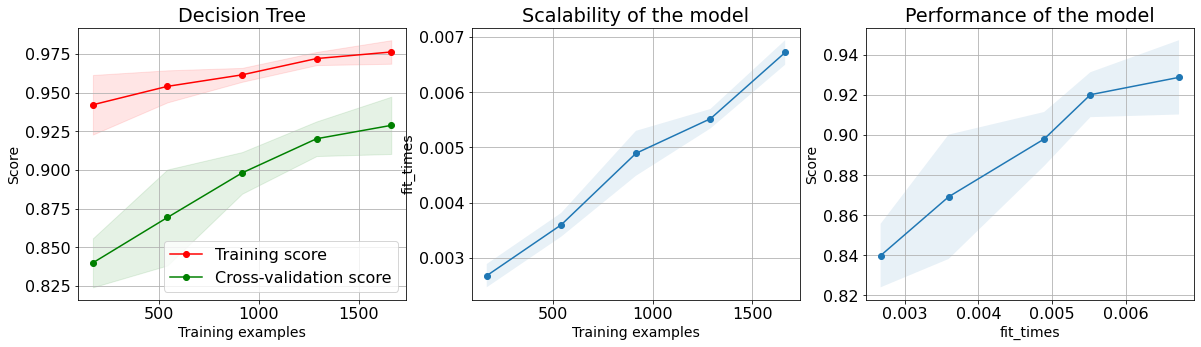

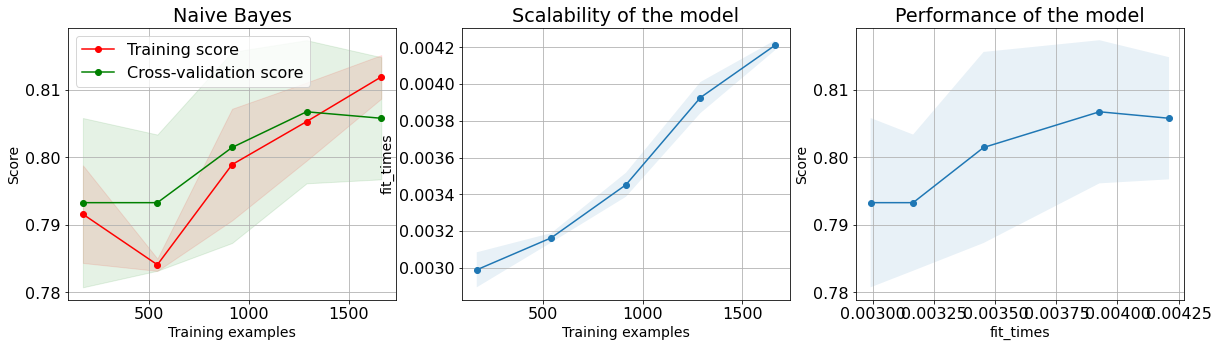

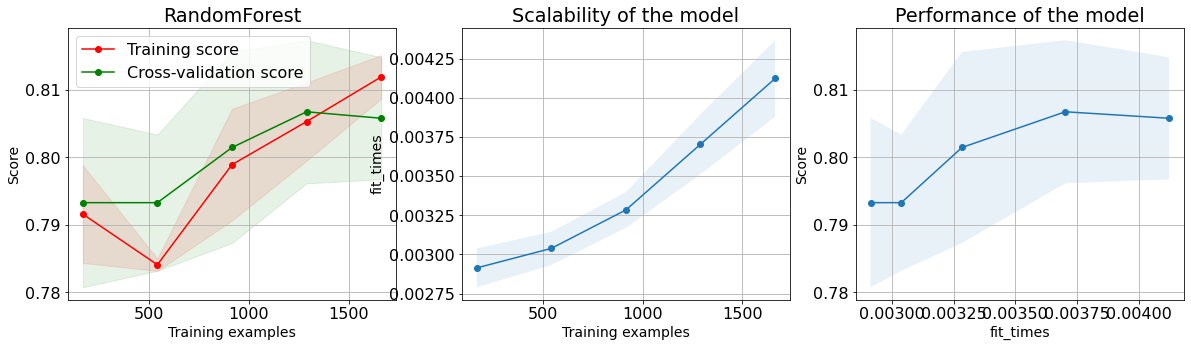

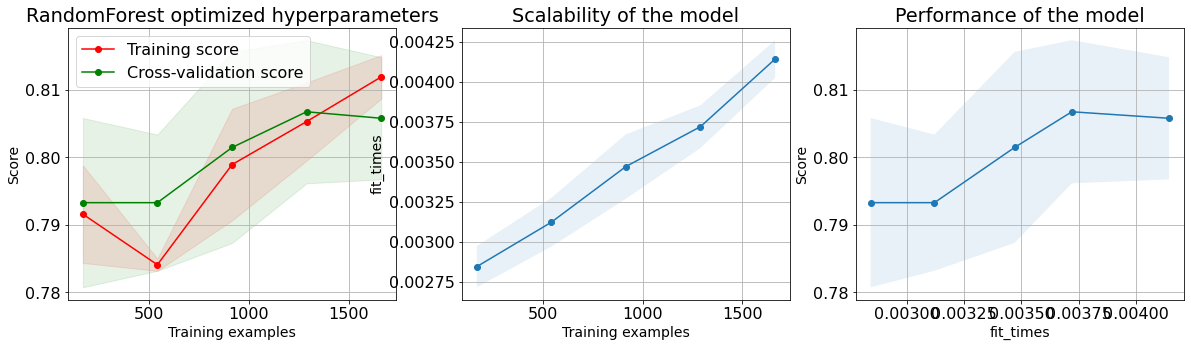

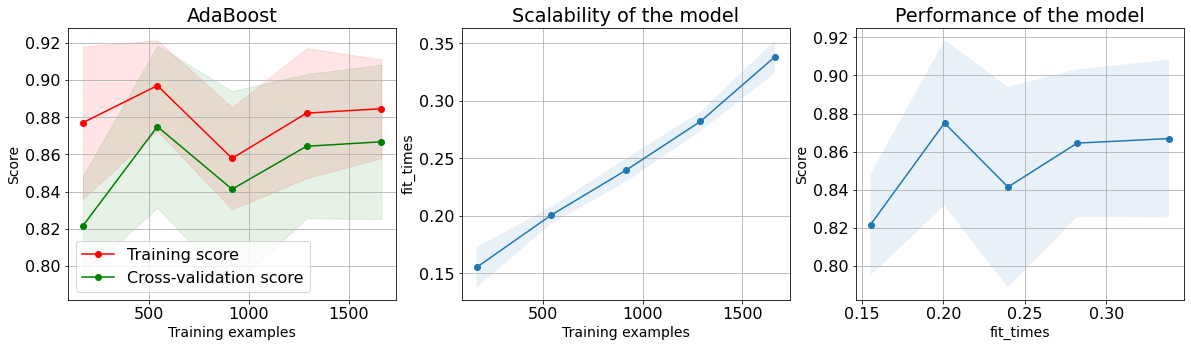

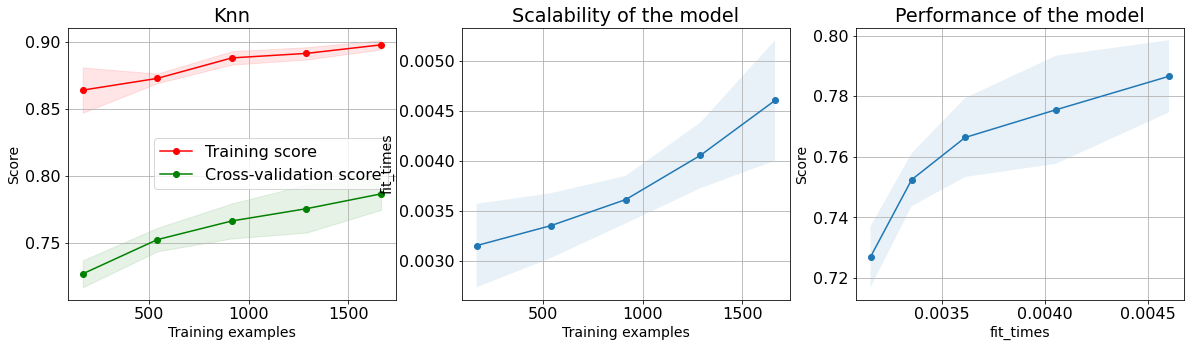

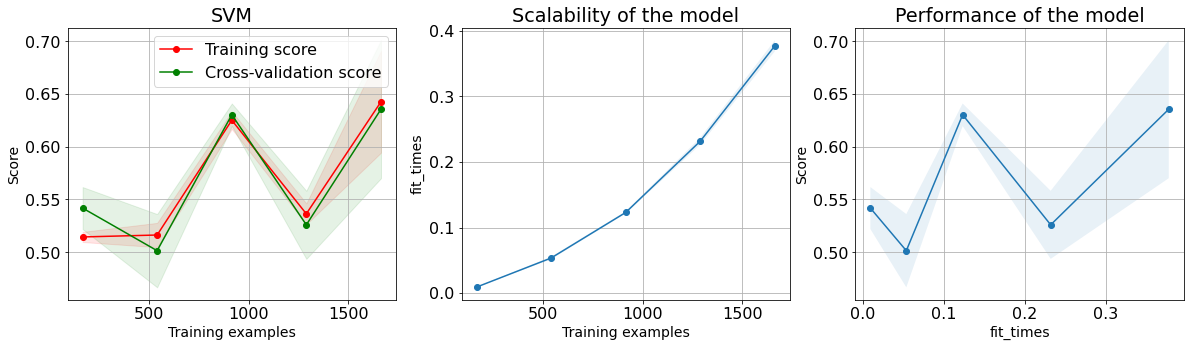

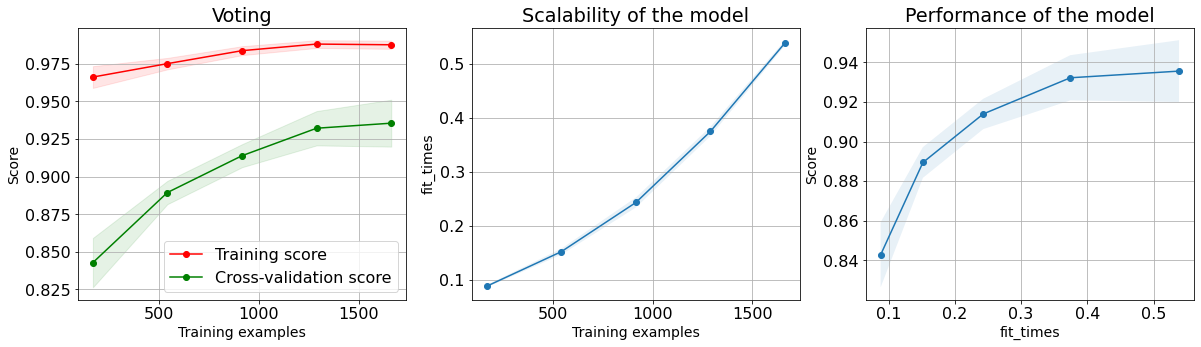

In [142]:
dt_plt = plot_learning_curve(dt,title="Decision Tree",X=train_set,y=train_label)
dt_plt.savefig('../output/task3/dt_plt.png')

gnb_plt = plot_learning_curve(gnb,title="Naive Bayes",X=train_set,y=train_label)
gnb_plt.savefig('../output/task3/gnb_plt.png')

rf_plt = plot_learning_curve(gnb,title="RandomForest",X=train_set,y=train_label)
rf_plt.savefig('../output/task3/rf_plt.png')

rf_optimized_plt = plot_learning_curve(gnb,title="RandomForest optimized hyperparameters",X=train_set,y=train_label)
rf_optimized_plt.savefig('../output/task3/rf_optimized_plt.png')

ada_plt = plot_learning_curve(ada,title="AdaBoost",X=train_set,y=train_label)
ada_plt.savefig('../output/task3/ada_plt.png')

knn_plt = plot_learning_curve(knn,title="Knn",X=train_set,y=train_label)
knn_plt.savefig('../output/task3/knn_plt.png')

svm_plt = plot_learning_curve(svm,title="SVM",X=train_set,y=train_label)
svm_plt.savefig('../output/task3/svm_plt.png')

voting_plt = plot_learning_curve(voting,title="Voting",X=train_set,y=train_label)
voting_plt.savefig('../output/task3/voting_plt.png')